In [2]:
#imports and read data

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import geopandas as gp

df = pd.read_csv(Path.cwd().parents[0]  / "CSV" / "Raw"/ "all_tweets.csv")
df.head()

,long,lat,post_guid,post_body,post_publish_date,post_language,hashtags,emoji
0,9.159337,45.461345,821687743382167552,L’esercito silenzioso delle #donne #migranti h...,2017-01-18 11:56:38,it,"{migranti,donne}",{}
1,12.545146,41.898417,821691034749009921,".@lauraravetto: #Migranti, “Che dice Minniti s...",2017-01-18 12:09:43,it,{Migranti},{}
2,-8.621914,41.162142,821690229597868032,#refugeecrisis https://t.co/JQoSFvMTbl,2017-01-18 12:06:31,und,{refugeecrisis},{}
3,12.545146,41.898417,821690521940881409,".@lauraravetto : #Migranti, “Che dice Minniti ...",2017-01-18 12:07:41,it,{Migranti},{}
4,-2.115866,53.073712,821693014267559936,""".@theresa_may: '""We can still have EU workers...",2017-01-18 12:17:35,en,"{Brexit,PMQs,immigration}",{}


In [3]:
#clean data

def clean_emoji(x):
    if x == '{}':
        return ''
    else:
        return x[1:-1]

df['emoji'] = df['emoji'].apply(clean_emoji)
df['hashtags'] = df['hashtags'].apply(lambda x:x[1:-1])

In [4]:
#make gdf
gdf = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.long, df.lat),crs = "epsg:4326")
gdf.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
world = gp.read_file(
    gp.datasets.get_path('naturalearth_lowres'),
    crs="epsg:4326")

tweets_worldjoin = gp.sjoin(gdf,world,how="left",op='within')
tweets_worldjoin.dropna(subset = ["index_right"],inplace =True)
tweets_worldjoin.info

<bound method DataFrame.info of              long        lat           post_guid  \
0        9.159337  45.461345  821687743382167552   
1       12.545146  41.898417  821691034749009921   
2       -8.621914  41.162142  821690229597868032   
3       12.545146  41.898417  821690521940881409   
4       -2.115866  53.073712  821693014267559936   
...           ...        ...                 ...   
168247   8.806506  45.831373  821674511187804160   
168248   4.476774  50.501174  821674745691246593   
168250  -3.703508  40.477795  821677990581043201   
168251   1.357922  51.379483  821681076779229186   
168252  -0.092910  51.514480  821685414423646208   

                                                post_body  \
0       L’esercito silenzioso delle #donne #migranti h...   
1       .@lauraravetto: #Migranti, “Che dice Minniti s...   
2                  #refugeecrisis https://t.co/JQoSFvMTbl   
3       .@lauraravetto : #Migranti, “Che dice Minniti ...   
4       ".@theresa_may: '"We can still

In [40]:
tweets_worldjoin.drop(columns = ['index_right','pop_est','continent', 'iso_a3','gdp_md_est'],inplace =True)

In [14]:
results = Counter()
tweets_worldjoin['name'].str.lower().str.split(',').apply(results.update)
results.most_common(5)

[('united kingdom', 40611),
 ('italy', 26120),
 ('germany', 20945),
 ('france', 20197),
 ('spain', 13013)]

In [33]:
tweets_worldjoin['post_publish_date'] = pd.to_datetime(tweets_worldjoin['post_publish_date'])
t1 = tweets_worldjoin['post_publish_date'].searchsorted('2017-01-20 00:00:00')
t2 = tweets_worldjoin['post_publish_date'].searchsorted('2017-02-20 00:00:00')
muslimban_tweets = tweets_worldjoin.loc[t1:t2-1]
muslimban_tweets.head()

,long,lat,post_guid,post_body,post_publish_date,post_language,hashtags,emoji,geometry,index_right,pop_est,continent,name,iso_a3,gdp_md_est
219,9.818380,46.764999,822167959024103424,Talking w/EU High Representative @FedericaMog ...,2017-01-19 19:44:51,en,"wef17,refugees",,POINT (9.81838 46.76500),127.0,8236303.0,Europe,Switzerland,CHE,496300.0
220,7.675785,45.072873,822169462430437376,@repubblicait #Immigrazione continua a essere ...,2017-01-19 19:50:49,it,Immigrazione,,POINT (7.67579 45.07287),141.0,62137802.0,Europe,Italy,ITA,2221000.0
221,-3.699242,40.420567,822170813277343744,Bienvenidos a Madrid 🇪🇸 #Madrid #refugeeswelco...,2017-01-19 19:56:11,es,"travel,refugeeswelcome,Madrid,exploremore,palace",🇪🇸,POINT (-3.69924 40.42057),132.0,48958159.0,Europe,Spain,ESP,1690000.0
223,19.393304,42.703612,822178276516962304,@nealmorse I'm working almost 14 month with #R...,2017-01-19 20:25:51,en,"longday,Refugees,Thanks,TSOAD",,POINT (19.39330 42.70361),173.0,642550.0,Europe,Montenegro,MNE,10610.0
224,-0.189190,51.503786,822177031681114112,Excellent work @RCA @GID_RCA open studio tonig...,2017-01-19 20:20:54,en,"empathy,refugeecrisis",,POINT (-0.18919 51.50379),143.0,64769452.0,Europe,United Kingdom,GBR,2788000.0


In [88]:
tweets_worldjoin['Month/Year'] = tweets_worldjoin['post_publish_date'].apply(lambda x: "%d/%d" % (x.month, x.year))
tweets_worldjoin['Month/Year'] = pd.to_datetime(tweets_worldjoin['Month/Year'])
country_frequency = tweets_worldjoin.groupby(['Month/Year', 'name']).size()

In [93]:
uk = country_frequency.xs("United Kingdom",level="name")
it = country_frequency.xs("Italy",level="name")
de = country_frequency.xs("Germany",level="name")
esp = country_frequency.xs("Spain",level="name")
fr = country_frequency.xs("France",level="name")
net = country_frequency.xs("Netherlands",level="name")

<ipython-input-110-a747a506cee6>:23: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('Tweets per year per country.jpg',quality =95,bbox_inches = 'tight')


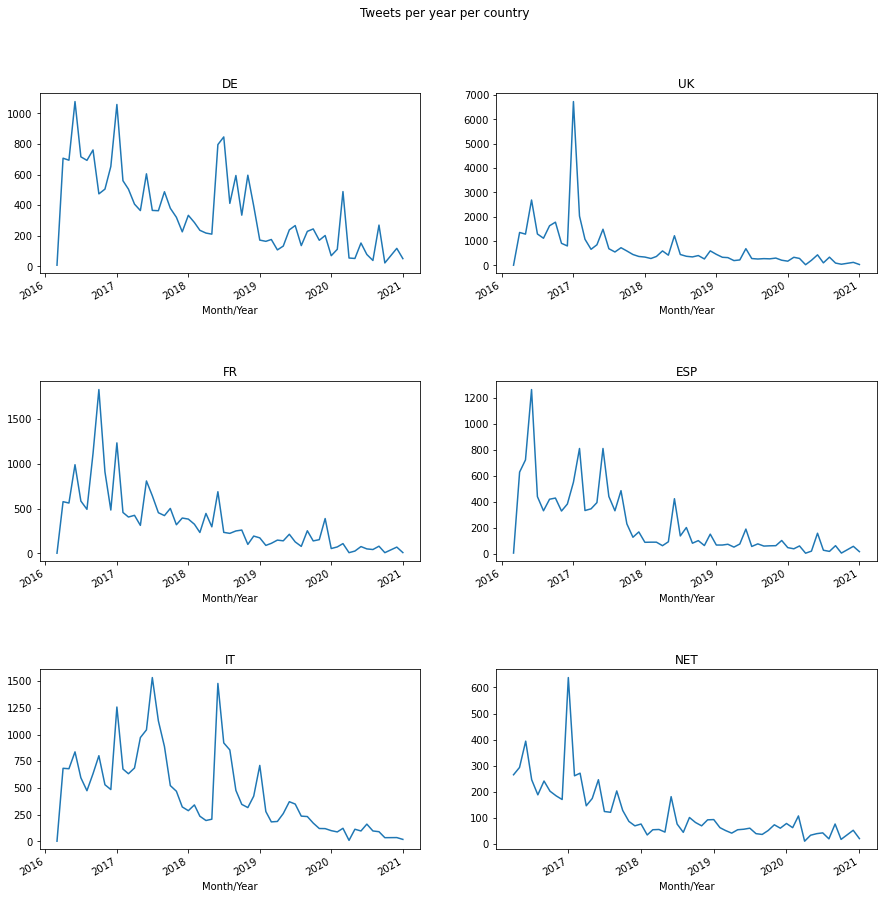

In [110]:
fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(ncols =2, nrows=3,figsize=(15,15))
fig.suptitle('Tweets per year per country')
fig.tight_layout()
plt.subplots_adjust(left  = 0.125,  # the left side of the subplots of the figure
                    right = 0.9,    # the right side of the subplots of the figure
                    bottom = 0.1,   # the bottom of the subplots of the figure
                    top = 0.9,      # the top of the subplots of the figure
                    wspace = 0.2,   # the amount of width reserved for blank space between subplots
                    hspace = 0.6,
                   )
ax1.title.set_text('DE')
ax2.title.set_text('UK')
ax3.title.set_text('FR')
ax4.title.set_text('ESP')
ax5.title.set_text('IT')
ax6.title.set_text('NET')
de.plot(ax=ax1)
uk.plot(ax=ax2)
fr.plot(ax=ax3)
esp.plot(ax=ax4)
it.plot(ax=ax5)
net.plot(ax=ax6)
#plt.savefig('Tweets per year per country.jpg',quality =95,bbox_inches = 'tight')

In [118]:
tweets_worldjoin.drop(columns =['long','lat'],
                     inplace=True
                     )
tweets_worldjoin.head()

,post_guid,post_body,post_publish_date,post_language,hashtags,emoji,geometry,name,Month/Year
0,821687743382167552,L’esercito silenzioso delle #donne #migranti h...,2017-01-18 11:56:38,it,"migranti,donne",,POINT (9.15934 45.46135),Italy,2017-01-01
1,821691034749009921,".@lauraravetto: #Migranti, “Che dice Minniti s...",2017-01-18 12:09:43,it,Migranti,,POINT (12.54515 41.89842),Italy,2017-01-01
2,821690229597868032,#refugeecrisis https://t.co/JQoSFvMTbl,2017-01-18 12:06:31,und,refugeecrisis,,POINT (-8.62191 41.16214),Portugal,2017-01-01
3,821690521940881409,".@lauraravetto : #Migranti, “Che dice Minniti ...",2017-01-18 12:07:41,it,Migranti,,POINT (12.54515 41.89842),Italy,2017-01-01
4,821693014267559936,""".@theresa_may: '""We can still have EU workers...",2017-01-18 12:17:35,en,"Brexit,PMQs,immigration",,POINT (-2.11587 53.07371),United Kingdom,2017-01-01


In [120]:
gdf = gp.read_file(Path.cwd().parents[0]/ 'Jupyter' /'countries.geojson')

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich